## Bandits in Pytorch

In [60]:
import torch
import math
import matplotlib.pyplot as plt
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


## Set up BanditEnv and run episodes

In [130]:
from multi_armed_bandit import BanditEnv

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

In [131]:
def random_policy():
    action = torch.multinomial(torch.ones(n_action), 1).item()
    return action

In [132]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]

In [133]:
for episode in range(n_episode):
    action = random_policy()
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a])
        else:
            action_avg_reward[a].append(0)

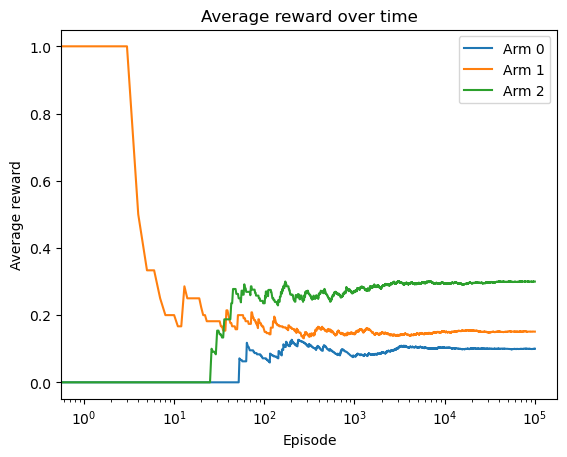

In [134]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

In [135]:
[round(bandit_payout[i] * bandit_reward[i],2) for i in range(len(bandit_payout))]

[0.1, 0.15, 0.3]

## Epsilon Greedy Algorithm

In [136]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

epsilon = 0.2
epsilon_greedy_policy = gen_epsilon_greedy_policy(n_action, epsilon)

In [137]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [138]:
for epsiode in range(n_episode):
    action = epsilon_greedy_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

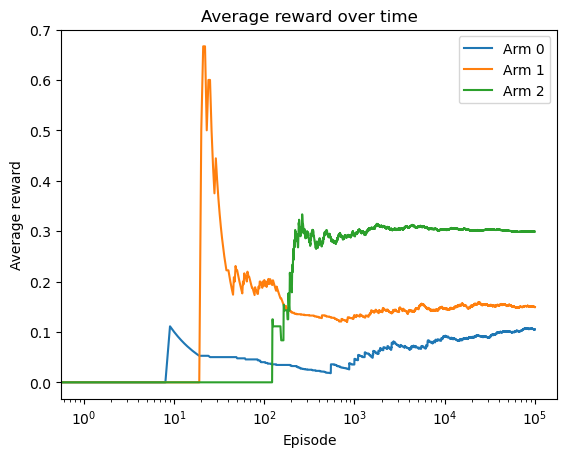

In [139]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Softmax Exploration

In [140]:
def gen_softmax_exploration_policy(tau):
    def policy_function(Q):
        probs = torch.exp(Q / tau)
        probs = probs / torch.sum(probs)
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function
tau = 0.1
softmax_exploration_policy = gen_softmax_exploration_policy(tau)

In [141]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [142]:
for epsiode in range(n_episode):
    action = softmax_exploration_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

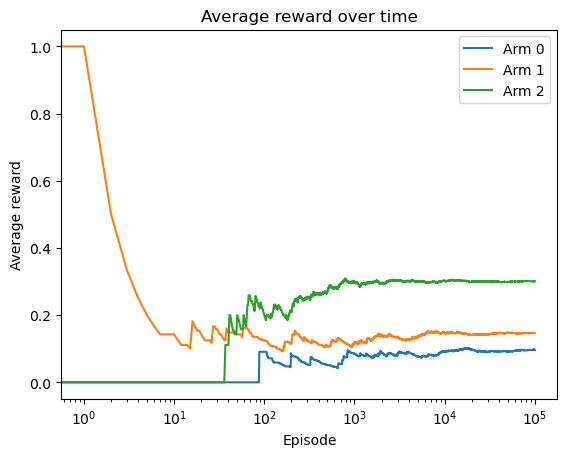

In [143]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Uppder Confidence Bound (UCB)

In [144]:
def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / 
                    action_count) + Q
    return torch.argmax(ucb).item()

In [145]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [146]:
for epsiode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, epsiode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

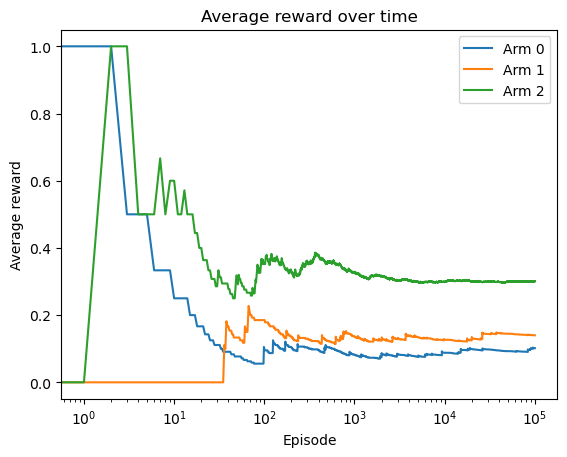

In [147]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Thomson Sampling

AttributeError: Text.set() got an unexpected keyword argument 'ax'

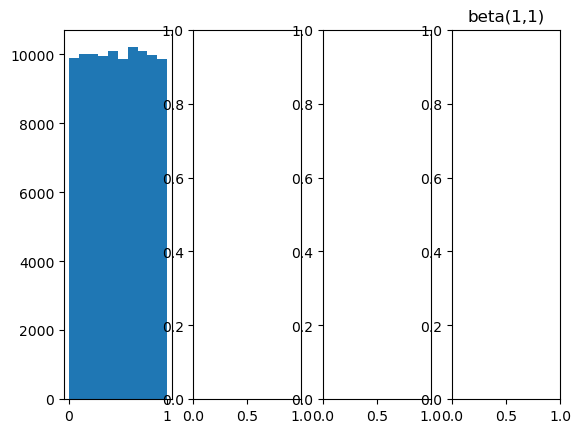

In [148]:
fig, axes = plt.subplots(1,4)

beta0 = torch.distributions.beta.Beta(1,1)
samples0 = [beta0.sample() for _ in range(100_000)]

beta1 = torch.distributions.beta.Beta(5,1)
samples1 = [beta1.sample() for _ in range(100_000)]

beta2 = torch.distributions.beta.Beta(1,5)
samples2 = [beta2.sample() for _ in range(100_000)]

beta3 = torch.distributions.beta.Beta(5,5)
samples3 = [beta3.sample() for _ in range(100_000)]

axes[0].hist(samples0, range=[0, 1], bins=10)
plt.title('beta(1,1)', ax=axes[0])
axes[1].hist(samples1, range=[0, 1], bins=10)
axes[1].title('beta(5,1)')
axes[2].hist(samples2, range=[0, 1], bins=10)
axes[2].title('beta(1,5)')
axes[3].hist(samples3, range=[0, 1], bins=10)
axes[3].title('beta(5,5)')
plt.show()

In [ ]:
def thompson_sampling(alpha, beta):
    prior_values = torch.distributions.beta.Beta(alpha, beta).sample()
    return torch.argmax(prior_values)

In [ ]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [ ]:
alpha = torch.ones(n_action)
beta = torch.ones(n_action)

In [ ]:
for episode in range(n_episode):
    action = thompson_sampling(alpha, beta)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    if reward > 0:
        alpha[action] += 1
    else:
        beta[action] += 1
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(    
                     action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

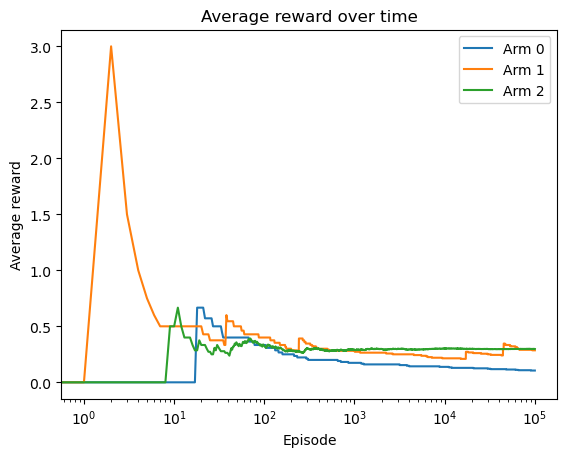

In [ ]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Contextual Bandit (2-States)

In [149]:
bandit_payout_machines = [
     [0.01, 0.015, 0.03],
     [0.025, 0.01, 0.015]
 ]
bandit_reward_machines = [
     [1, 1, 1],
     [1, 1, 1]
 ]

In [150]:
n_machine = len(bandit_payout_machines)

In [157]:
bandit_env_machines = [BanditEnv(bandit_payout, bandit_reward)
           for bandit_payout, bandit_reward in
           zip(bandit_payout_machines, bandit_reward_machines)]

In [158]:
n_episode = 100000
n_action = len(bandit_payout_machines[0])
action_count = torch.zeros(n_machine, n_action)
action_total_reward = torch.zeros(n_machine, n_action)
action_avg_reward = [[[] for action in range(n_action)] for _ in range(n_machine)]

In [159]:
Q_machines = torch.empty(n_machine, n_action)

In [160]:
for episode in range(n_episode):
    state = torch.randint(0, n_machine, (1,)).item()
    action = upper_confidence_bound(
            Q_machines[state], action_count[state], episode)
    reward = bandit_env_machines[state].step(action)
    action_count[state][action] += 1
    action_total_reward[state][action] += reward
    Q_machines[state][action] = action_total_reward[state][action] / action_count[state][action]
    for a in range(n_action):
        if action_count[state][a]:
            action_avg_reward[state][a].append(
                        action_total_reward[state][a] / action_count[state][a])
        else:
            action_avg_reward[state][a].append(0)

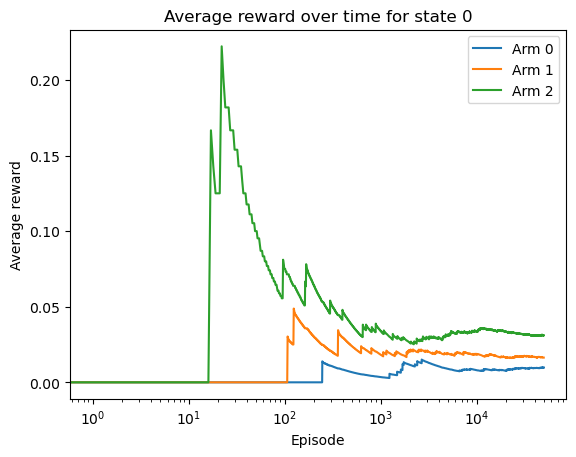

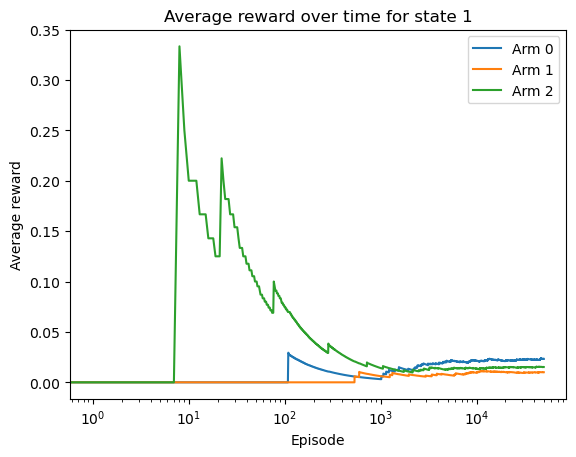

In [163]:
import matplotlib.pyplot as plt
for state in range(n_machine):
    for action in range(n_action):
        plt.plot(action_avg_reward[state][action])
    plt.legend(['Arm {}'.format(action) 
                     for action in range(n_action)])
    plt.xscale('log')
    plt.title('Average reward over time for state {}'.format(state))
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.show()